# Parameter tests

Tests for self-reliance, attitude, and fixed attitude influence

In [1]:
import os
import numpy as np
from importlib import reload
from dataclasses import *

import AvantgardeModelUtils
reload(AvantgardeModelUtils)
from AvantgardeModelUtils import *

BINARY_CLUSTER_BINS = np.arange(0, 1, 0.5)

In [2]:
location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

files = []
for fname in os.listdir(location):
    if ".0" in fname and "_mode" in fname:        
        files.append(os.path.join(location, fname))
        
print(files[-1])


..\data\paramstest\agent_data_beta-goal_mode-0.90_concentration-5.0.csv


In [4]:
def find_file(key, val, m):
    for file in files:
        if val in file and m in file and key in file:
            return file

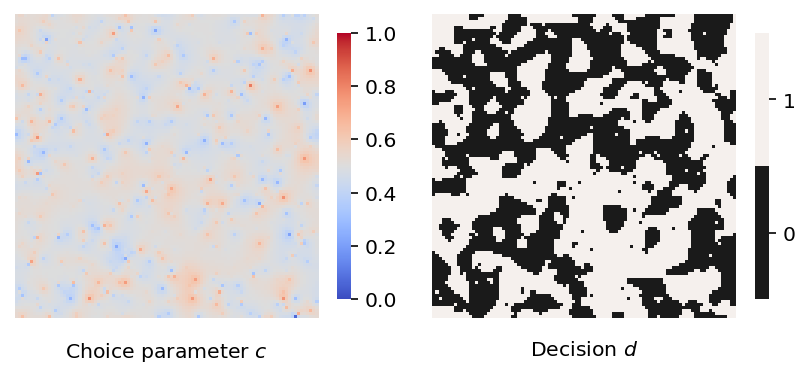

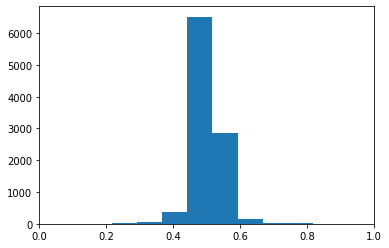

In [5]:
# show file
file = find_file("goal", "mode-0.5", "10.")
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

finalstep = 100

xseed = 100
sample = data.query("seed == @xseed")

ShowState(Grid(Choice(sample, finalstep)))

plt.figure()
plt.hist(sample.query("step == @finalstep").get("affinity"), bins=10)
plt.xlim([0, 1])
plt.show()

In [22]:
# show file
file = find_file("goal", "mode-0.5", "10.")
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]
data = LoadSimulation(file, columns=columns)

finalstep = 100

xseed = 100
sample = data.query("seed == @xseed")

N = 100
Aii = sample.query("step == @finalstep").get("affinity").values
decisions = np.int32(Aii.reshape(N, N) >= 0.5)
unique = np.unique(decisions)

row_indices, col_indices = np.where(decisions == 0)
indices = list(zip(row_indices, col_indices))

def get_neighbour_indices(i, j, Nx, Ny):
    """
    Returns the list of neighboring indices for a cell at position (i, j)
    in a 2D grid with periodic boundary conditions and dimensions Nx x Ny.
    """
    di_values = [-1, 0, 1]
    dj_values = [-1, 0, 1]
    neighbours = [((i+di) % Nx, (j+dj) % Ny)
                 for di in di_values
                 for dj in dj_values
                 if di != 0 or dj != 0]
    return neighbours

def count_neighbours(index_list, Nx, Ny):
    """
    Counts the number of neighbors for each index in a list of 2D indices
    with periodic boundary conditions and dimensions Nx x Ny.
    """
    index_set = frozenset(index_list)
    neighbours = [0] * len(index_list)
    for i, index in enumerate(index_list):
        neighbour_indices = get_neighbour_indices(index[0], index[1], Nx, Ny)
        neighbour_set = frozenset(neighbour_indices)
        count = len(neighbour_set.intersection(index_set))
        #count = sum(1 for ni, nj in neighbour_indices if list((ni, nj)) in index_list)
        neighbours[i] = count
    return neighbours

def mean_degree(data, decision, finalstep=100):
    if type(data) == pd.DataFrame:
        Aii = data.query("step == @finalstep").get("affinity").values
    else:
        Aii = data
    N = 100
    Na = 8
    decisions = np.int32(Aii.reshape(N, N) >= 0.5)
    row_indices, col_indices = np.where(decisions == decision)
    indices = list(zip(row_indices, col_indices))
    links = count_neighbours(indices, N, N)
    return np.mean(links) / Na

mean_degree(sample, 0)

0.842568866111467

In [17]:
%%timeit
counts = count_neighbours(indices, N, N)

39 ms ± 1.07 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [131]:
# Compare cluster connectivity with degree connectivity
# -----------------------------------------------------
import numpy as np
from BlockNNClustering import *

def connectivity(labels):
    unique_labels_, counts_ = np.unique(labels, return_counts=True)
    noise_count_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
    sizes_ = counts_[unique_labels_ >= 0]
    n_clusters = sizes_.size
    n_agents = np.sum(counts_[unique_labels_ >= -1])
    return (n_agents - (n_clusters + noise_count_)) / (n_agents - 1)


# (a) timeline
################
# arrange
cluster_builder = BlockNNClustering()
t = np.arange(0, 40, 2)

# load data
stack = []
seeds = [i for i in range(100, 109)]
for seed in seeds:
    file = f"../data/uniform/data_A_seed{seed}.csv"
    attitudes = np.genfromtxt(file, delimiter=' ')
    #print(f"Shape: {attitudes.shape}")

    stack_ = []
    for ti in t:
        Aii = attitudes[ti]
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)
        _, (pos, neg) = cluster_builder.fit(decisions)
        cpos = connectivity(pos)
        cneg = connectivity(neg)
        mdpos = mean_degree(Aii, 1)
        mdneg = mean_degree(Aii, 0)
        stack_.append([cpos, cneg, mdpos, mdneg])

    stack.append(stack_)

# save data
stack = np.array(stack)

In [138]:
# (b) individuality
####################
x = []
N = 100
concentration = "10.0"
parameter = "avantgarde"
        
# select files
location = "..\data\paramstest"
file = "agent_beta-avantgarde_"

files = []
for fname in os.listdir(location):
    if f"-{parameter}" in fname and "_mode" in fname:
        if fname.split("concentration-")[1].split(".csv")[0] == concentration and \
            np.round(float(fname.split("mode-")[1].split("_concentration")[0]), 1) in np.round(np.arange(0.1, 0.91, 0.05), 2):
            files.append(os.path.join(location, fname))

# load data
stack2 = []
for file in files:
    data = LoadSimulation(file, columns=columns)
    
    # calculate properties
    x.append(data.query("step == 0").get("avantgarde").mean())

    # get clusters
    stack2_ = []
    for seed, df in data.query("step == 100").groupby("seed"):
        if int(seed) not in seeds:
            continue
            
        Aii = df.get("affinity").values
        decisions = np.int32(Aii.reshape(N, N) >= 0.5)
        _, (pos, neg) = cluster_builder.fit(decisions)
        cpos = connectivity(pos)
        cneg = connectivity(neg)
        mdpos = mean_degree(Aii, 1)
        mdneg = mean_degree(Aii, 0)
        stack2_.append([cpos, cneg, mdpos, mdneg])

    stack2.append(stack2_)

# save
stack2 = np.array(stack2)

In [139]:
means, stderr = [], []
for i, _ in enumerate(t):
    means.append(stack[:,i].mean(axis=0))
    stderr.append(stack[:,i].std(axis=0) / np.sqrt(10))
    
means = np.array(means)
stderr = np.array(stderr)

means2, stderr2 = [], []
for i, _ in enumerate(x):
    means2.append(stack2[i,:].mean(axis=0))
    stderr2.append(stack2[i,:].std(axis=0) / np.sqrt(10))
    
means2 = np.array(means2)
stderr2 = np.array(stderr2)

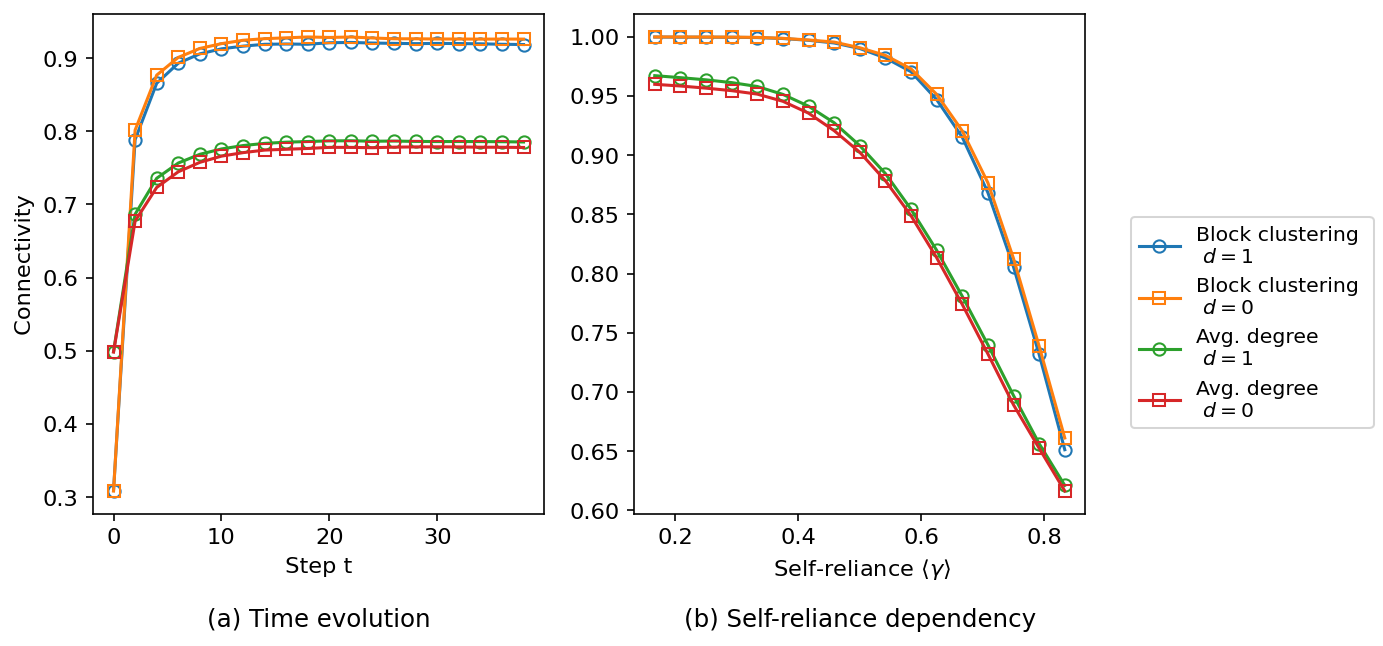

In [179]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4.5))
plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

ax1.errorbar(t[:], means[:,0][0:], marker='o', mfc='none', label="Block clustering \n " + r"$d=1$")
ax1.errorbar(t[:], means[:,1][0:], marker='s', mfc='none', label="Block clustering \n " + r"$d=0$")
ax1.errorbar(t[:], means[:,2][0:], marker='o', mfc='none', label="Avg. degree \n "+r"$d=1$")
ax1.errorbar(t[:], means[:,3][0:], marker='s', mfc='none', label="Avg. degree \n "+r"$d=0$")

ax2.errorbar(x, means2[:,0], marker='o', mfc='none', label=r"Block clustering | $d=1$")
ax2.errorbar(x, means2[:,1], marker='s', mfc='none', label=r"Block clustering | $d=0$")
ax2.errorbar(x, means2[:,2], marker='o', mfc='none', label=r"Avg. degree | $d=1$")
ax2.errorbar(x, means2[:,3], marker='s', mfc='none', label=r"Avg. degree | $d=0$")

ax1.set_ylabel(" Connectivity ")
ax1.set_xlabel(" Step t ")
ax2.set_xlabel(r" Self-reliance $\langle \gamma \rangle$ ")

lables, handles = ax1.get_legend_handles_labels()
fig.legend(lables, handles, loc="right", fontsize=10)
#ax2.legend(loc="best", fontsize=10)
fig.subplots_adjust(right=0.8)

ax1.set_title("(a) Time evolution", y=-0.25, loc="center", fontsize=12)
ax2.set_title("(b) Self-reliance dependency", y=-0.25, loc="center", fontsize=12)

plt.show()

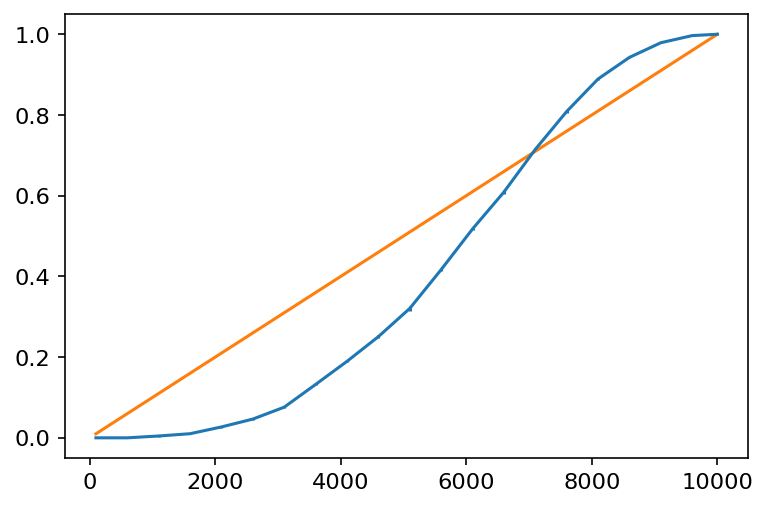

In [226]:
import numpy as np

def calculate_average_cells(N, M, r):
    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    grid[np.unravel_index(indices, (N, N))] = 1
    avg_cells = 0
    for i in range(N-M+1):
        for j in range(N-M+1):
            subgrid = grid[i:i+M, j:j+M]
            avg_cells += np.sum(subgrid)
    avg_cells /= (N-M+1)**2
    return avg_cells


def get_avg_degree(N, r):
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    indices = np.unravel_index(indices, (N, N))
    indices = list(zip(indices[0], indices[1]))
    return np.mean(count_neighbours(indices, N, N)) / 8


def get_connectivity(N, r):
    my_clustering = BlockNNClustering()
    grid = np.zeros((N, N))
    indices = np.random.choice(np.arange(N*N), size=r, replace=False)
    grid[np.unravel_index(indices, (N, N))] = 1
    _, labels = my_clustering.fit(grid)
    
    if len(labels) == 1:
        return 1.
    neg, pos = labels
    return connectivity(pos)

n_loops = 6
k = np.arange(100, 10000, 500)
k = np.append(k, 10000)
counts, counts2 = [], []
for kj in k:
    N = 100
    results = [get_connectivity(100, kj) for _ in range(n_loops)]
    results2 = [get_avg_degree(100, kj) for _ in range(n_loops)]
    counts.append([np.mean(results), np.std(results) / np.sqrt(n_loops)])
    counts2.append([np.mean(results2), np.std(results2) / np.sqrt(n_loops)])


Text(0, 0.5, 'Connectivity')

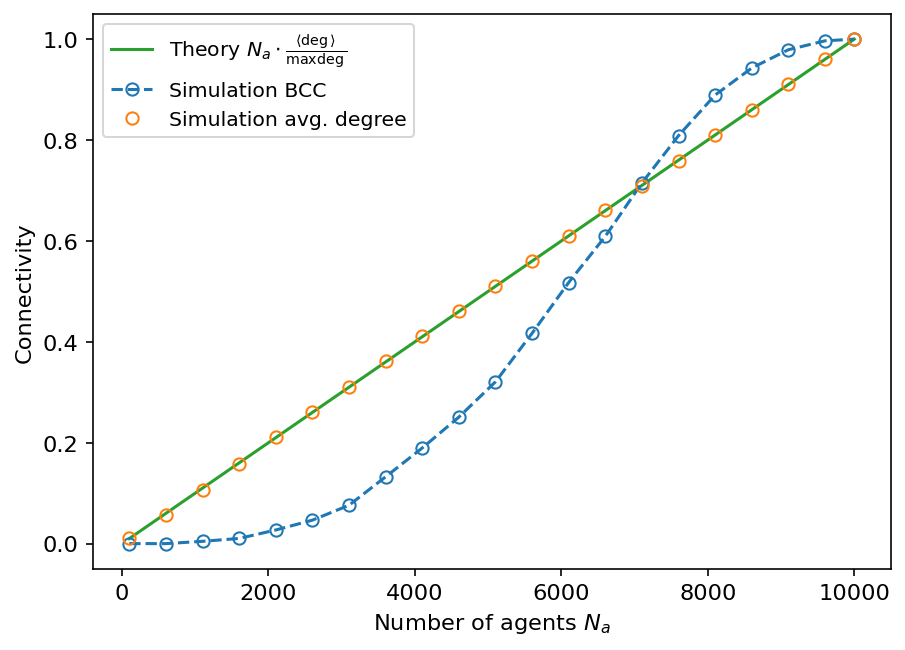

In [236]:
fig, ax = plt.subplots(figsize=(7, 5))

counts = np.array(counts)
counts2 = np.array(counts2)

ax.errorbar(k, counts[:,0], marker='o', mfc='none', linestyle="--", label=r"Simulation BCC")
ax.errorbar(k, counts2[:,0], marker='o', mfc='none', linestyle="", label=r"Simulation avg. degree")
ax.plot(k, k *1 / 10000, label=r"Theory $N_a \cdot \frac{\langle \deg \rangle}{\max \deg}$")

ax.legend(fontsize=10)
ax.set_xlabel(r"Number of agents $N_a$")
ax.set_ylabel("Connectivity")
#ax.set_title("", y=-0.25)

In [5]:
columns = ["step", "id", "avantgarde", "affinity", "affinityGoal", "seed"]

In [148]:
plot_data = {}

keys = ("avantgarde", "affinityGoal", "affinity")
fkeys = ("avantgarde", "goal", "affinity")
for num in ("10.0", "5.0"):
    plot_data[num] = {}
    
    for (key, fkey) in zip(keys, fkeys):

        # select files
        location = "..\data\paramstest"
        file = "agent_beta-avantgarde_"

        files = []
        for fname in os.listdir(location):
            if f"-{num}" in fname and f"-{fkey}" in fname \
                and "_mode" in fname:        
                files.append(os.path.join(location, fname))

        # load data
        x, means, stds, modes = [], [], [], []
        for file in files:
            data = LoadSimulation(file, columns=columns)

            # calculate properties
            modes.append(float(file.split("mode-")[1].split("_")[0]))
            xi = data.query("step == 0").get(key).mean()
            m = data.query("step == @finalstep").groupby("seed").mean().get("affinity")
            std = data.query("step == @finalstep").groupby("seed").std().get("affinity")

            x.append(xi)
            means.append(m)
            stds.append(std)

        # save
        plot_data[num][key] = {"x": x, "m": means, "std": stds, "mode": modes}

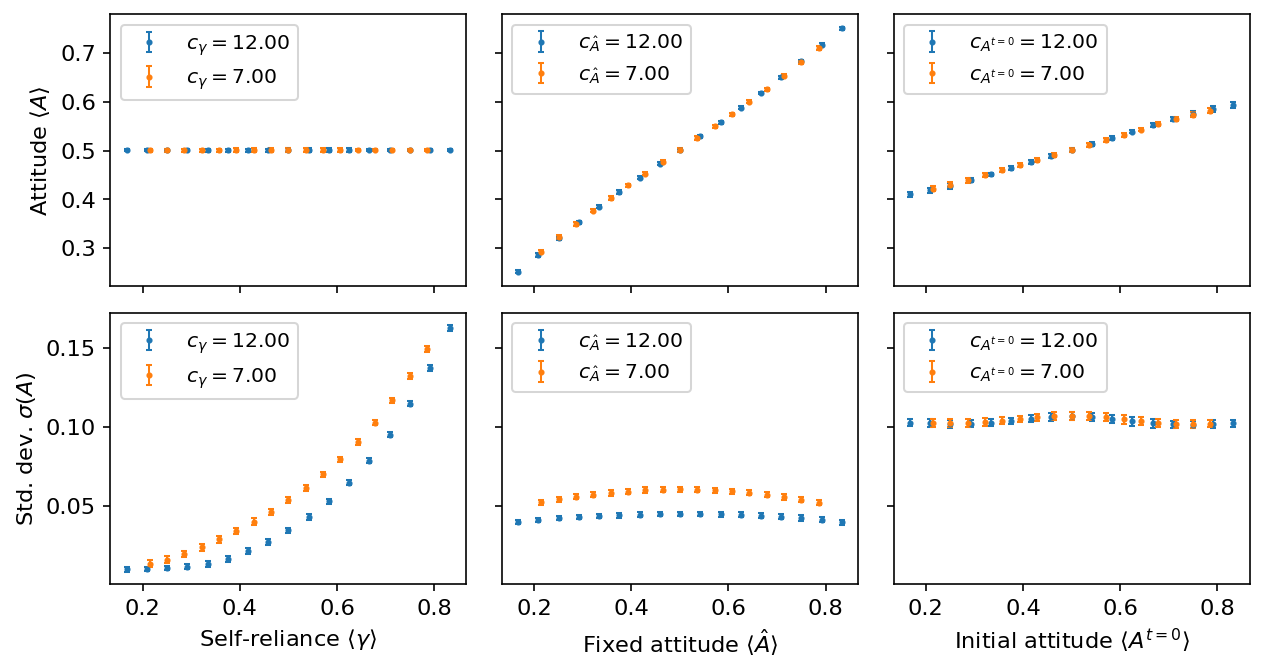

In [271]:
fig, ax = plt.subplots(2, 3, sharey="row", sharex="col", figsize=(10, 5))

plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

labels = (r"Self-reliance $\langle \gamma \rangle$", r"Fixed attitude $\langle \hat{A} \rangle$", r"Initial attitude $\langle A^{t=0} \rangle$")
signs = ("{\gamma}", "{\hat{A}}", "{A^{t=0}}")
# plot mean
for i, axis in enumerate(ax[0]):
    key = keys[i][0]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean() for _x in _data[key]["m"]], 
                      yerr=[_x.std() for _x in _data[key]["m"]], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        
    #axis.set_ylim([0, 1])
    axis.legend(fontsize=10, loc="upper left")
    

# plot variance
for i, axis in enumerate(ax[1]):
    key = keys[i][0]
    for num, _data in plot_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        axis.errorbar(_data[key]["x"], [_x.mean() for _x in _data[key]["std"]], 
                      yerr=[_x.std() for _x in _data[key]["std"]],
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
    
    #axis.set_xlim([0, 1])
    axis.legend(fontsize=10, loc="upper left")
    axis.set_xlabel(labels[i], fontsize=11)

ax[0, 0].set_ylabel(r"Attitude $\langle A \rangle$")
ax[1, 0].set_ylabel(r"Std. dev. $\sigma(A)$")

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

# labels = [r"$c_X=12.0$", r"$c_X=7.0$"]
# legend_elements = [Line2D([0], [0], linestyle="", marker='o', markerfacecolor="tab:blue", markeredgecolor="black", markersize=10),
#                    Line2D([0], [0], linestyle="", marker='o', markerfacecolor="tab:orange", markeredgecolor="black", markersize=10),
#                    #Line2D([0], [0], linestyle="", marker='s', markerfacecolor="r", markeredgecolor="black", markersize=10)
#                   ]
# fig.legend(legend_elements, labels, loc='upper center', ncol=2)
plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9)
plt.show()

In [155]:
import BlockNNClustering
reload(BlockNNClustering)
from BlockNNClustering import *

from dataclasses import *
import numpy as np

# Class for saving cluster information 
# of a single agent selection
@dataclass
class Clusters:
    noise_count: int
    sizes: np.ndarray
    
    @staticmethod
    def build(labels):
        unique_labels_, counts_ = np.unique(labels, return_counts=True)
        noise_count_ = counts_[unique_labels_ == -1][0] if -1 in unique_labels_ else 0
        sizes_ = counts_[unique_labels_ >= 0]
        return Clusters(noise_count_, sizes_)
    
    def tolist(self): # includes noise
        size_list = self.counts[self.unique_labels >= 0].tolist()
        size_list.extend([1 for _ in range(self.n_noise)])
        return size_list
    
# Class for saving cluster information
# of a single state
@dataclass
class StateClusters:
    positive: Clusters
    negative: Clusters
        
    @staticmethod
    def build(all_labels):
        labels_neg_, labels_pos_ = all_labels
        pos_ = Clusters.build(labels_pos_)
        neg_ = Clusters.build(labels_neg_)
        return StateClusters(pos_, neg_)
    
@dataclass
class StateClusterStats:
    positive: list
    negative: list
    seeds: list
    
    @staticmethod
    def create():
        return StateClusterStats([], [], [])
    
    def add(self, state_clusters, seed):
        self.positive.append(state_clusters.positive)
        self.negative.append(state_clusters.negative)
        self.seeds.append(seed)
        
    def n(self, filtered=""):
        if filtered == "positive":
            return np.array([p_.n for p_ in self.positive])
        elif filtered == "negative":
            return np.array([n_.n for n_ in self.negative])
        else:
            return np.array(
                [c.n for c in self.positive]
                            .extend([n_.n for n_ in self.negative])
            )


block_clustering = BlockNNClustering(min_cluster_size=1)
cluster_data = {}
N = 100

keys = [("avantgarde", "avantgarde"), ("affinityGoal", "goal"), ("affinity", "affinity")]
for num in ("10.0", "5.0"):
    cluster_data[num] = {}
    
    for (key, fkey) in keys:

        # select files
        location = "..\data\paramstest"
        file = "agent_beta-avantgarde_"

        files = []
        for fname in os.listdir(location):
            if f"-{num}" in fname and f"-{fkey}" in fname \
                and "_mode" in fname:         
                files.append(os.path.join(location, fname))

        # load data
        x, clusters, modes = [], [], []
        for file in files:
            print(file)
            data = LoadSimulation(file, columns=columns)
            modes.append(float(file.split("mode-")[1].split("_")[0]))
            
            # calculate properties
            xi = data.query("step == 0").get(key).mean()
            scs = StateClusterStats.create()
            
            # get clusters
            for seed, df in data.query("step == 100").groupby("seed"):
                Aii = df.get("affinity").values
                decisions = np.int32(Aii.reshape(N, N) >= 0.5)
                unique = np.unique(decisions)
                if unique.size == 1:
                    is_pos = unique[0] == 1
                    if is_pos: 
                        pos = np.zeros(decisions.shape)
                        neg = np.ones(decisions.shape) * (-2)
                    else:
                        pos = np.ones(decisions.shape) * (-2)
                        neg = np.zeros(decisions.shape)
    
                    _, all_labels = (None, (neg, pos))
                else:
                    _, all_labels = block_clustering.fit(decisions)
                scs.add(StateClusters.build(all_labels), seed)
            
            x.append(xi)
            clusters.append(scs)

        # save
        cluster_data[num][key] = {"x": x, "mode": modes, "clusters": clusters}


..\data\paramstest\agent_data_beta-avantgarde_mode-0.10_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.15_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.20_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.25_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.30_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.35_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.40_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.45_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.50_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.55_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.60_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.65_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0

In [359]:
import BlockNNClustering
reload(BlockNNClustering)
from BlockNNClustering import *

from dataclasses import *
import numpy as np

connectivity_data = {}

N = 100
keys = [("avantgarde", "avantgarde"), ("affinityGoal", "goal"), ("affinity", "affinity")]
for num in ("10.0", "5.0"):
    connectivity_data[num] = {}
    
    for (key, fkey) in keys:

        # select files
        location = "..\data\paramstest"
        file = "agent_beta-avantgarde_"

        files = []
        for fname in os.listdir(location):
            if f"-{num}" in fname and f"-{fkey}" in fname \
                and "_mode" in fname:         
                files.append(os.path.join(location, fname))

        # load data
        x, conn0, conn1 = [], [], []
        for file in files:
            print(file)
            data = LoadSimulation(file, columns=columns)
            
            # calculate properties
            xi = data.query("step == 0").get(key).mean()
            
            # get clusters
            stat0, stat1 = [], []
            for seed, df in data.query("step == 100").groupby("seed"):
                stat0.append(connectivity_real(df, 0))
                stat1.append(connectivity_real(df, 1))
            
            x.append(xi)
            conn0.append(stat0)
            conn1.append(stat1)

        # save
        connectivity_data[num][key] = {"x": x, "connectivity 0": conn0, "connectivity 1": conn1}


..\data\paramstest\agent_data_beta-avantgarde_mode-0.10_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.15_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.20_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.25_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.30_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.35_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.40_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.45_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.50_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.55_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.60_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0.65_concentration-10.0.csv
..\data\paramstest\agent_data_beta-avantgarde_mode-0

C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


..\data\paramstest\agent_data_beta-goal_mode-0.15_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.20_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.25_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.30_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.35_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.40_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.45_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.50_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.55_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.60_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.65_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.70_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.75_concentration-10.0.csv
..\data\paramstest\agent_data_beta-goal_mode-0.80_c

In [357]:
file = "../data/paramstest/agent_data_beta-goal_mode-0.15_concentration-5.0.csv"
data = LoadSimulation(file, columns=columns)
            
# calculate properties
xi = data.query("step == 0").get(key).mean()

# get clusters
stat0, stat1 = [], []
for seed, df in data.query("step == 100").groupby("seed"):
    stat0.append(connectivity_real(df, 0))
    stat1.append(connectivity_real(df, 1))
    
print(xi)

0.4998465218844295


C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
C:\Users\hoedtke\AppData\Local\Programs\Python\Python310\lib\site-packages\numpy\core\_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


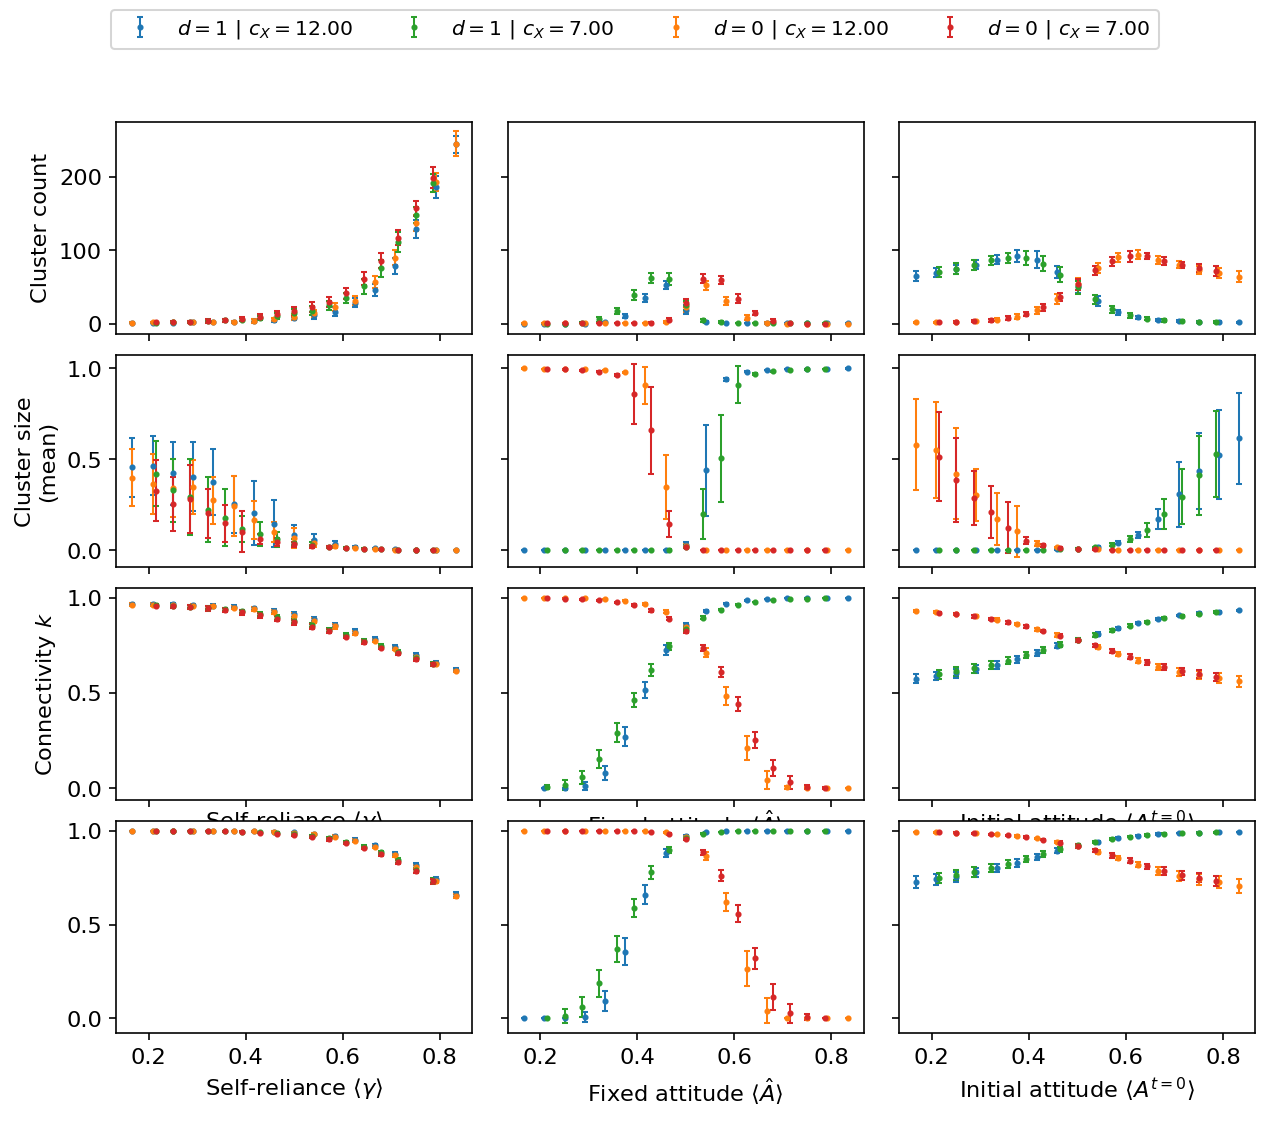

In [361]:
def number_of_clusters(stats):
    return [c_.sizes.size for c_ in stats.positive]

def number_of_clusters_neg(stats):
    return [c_.sizes.size for c_ in stats.negative]

def connectivity(stats):
    out = []
    for cluster in stats.positive:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

def connectivity_neg(stats):
    out = []
    for cluster in stats.negative:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

def noise_count(stats):
    return [c_.noise_count for c_ in stats.positive]

def noise_count_neg(stats):
    return [c_.noise_count for c_ in stats.negative]

N = 10000
def avg_size(stats):
    return [c_.sizes.mean()/N if c_.sizes.any() else 0 for c_ in stats.positive]

def avg_size_neg(stats):
    return [c_.sizes.mean()/N if c_.sizes.any() else 0 for c_ in stats.negative]


fig, ax = plt.subplots(4, 3, sharey="row", sharex="col", figsize=(10, 8))

plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

labels = (r"Self-reliance $\langle \gamma \rangle$", r"Fixed attitude $\langle \hat{A} \rangle$", r"Initial attitude $\langle A^{t=0} \rangle$")
# plot mean
for i, axis in enumerate(ax[0]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [number_of_clusters(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$d=1\ |\ c_X={float(num)+2:.2f}$")
        
        n_clusters = [number_of_clusters_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$d = 0\ |\ c_X={float(num)+2:.2f}$")
        
        
    #axis.set_ylim([0, 1])
    #axis.legend(fontsize=10, loc="upper left")

# plot variance
for i, axis in enumerate(ax[2]):
    key = keys[i][0]
    for num, _data in connectivity_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        
        n_clusters = _data[key]["connectivity 1"] #[connectivity(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = _data[key]["connectivity 0"] #[connectivity_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        axis.set_xlabel(labels[i], fontsize=11)
    
# plot variance
for i, axis in enumerate(ax[3]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [connectivity(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = [connectivity_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        axis.set_xlabel(labels[i], fontsize=11)
        
# plot variance
for i, axis in enumerate(ax[1]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [avg_size(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = [avg_size_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
    
    #axis.set_xlim([0, 1])
    #axis.legend(fontsize=10, loc="best")
    

ax[0, 0].set_ylabel(r"Cluster count")
ax[2, 0].set_ylabel(r"Connectivity $k$")
ax[1, 0].set_ylabel("Cluster size\n(mean)")

marks, labels = ax[0, 0].get_legend_handles_labels()
indices = [0, 2, 1, 3]
marks = sorted(marks, key=lambda x: indices.index(marks.index(x)))
labels = sorted(labels, key=lambda x: indices.index(labels.index(x)))
fig.legend(marks, labels, loc='upper center', ncol=4, fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9)
plt.show()

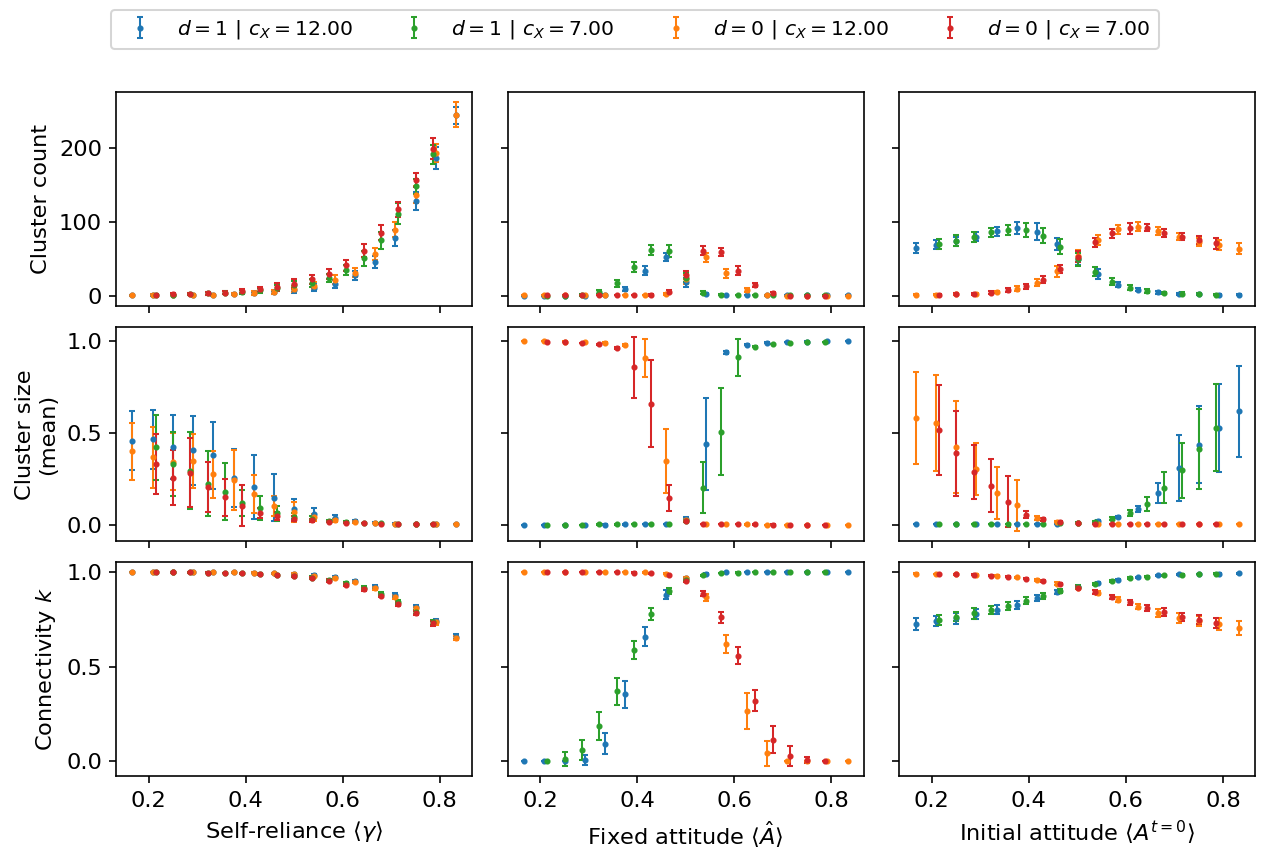

In [272]:
def number_of_clusters(stats):
    return [c_.sizes.size for c_ in stats.positive]

def number_of_clusters_neg(stats):
    return [c_.sizes.size for c_ in stats.negative]

def connectivity(stats):
    out = []
    for cluster in stats.positive:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

def connectivity_network(stats):
    out = []
    for cluster in stats.positive:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out
    

def connectivity_neg(stats):
    out = []
    for cluster in stats.negative:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

def noise_count(stats):
    return [c_.noise_count for c_ in stats.positive]

def noise_count_neg(stats):
    return [c_.noise_count for c_ in stats.negative]

N = 10000
def avg_size(stats):
    return [c_.sizes.mean()/N if c_.sizes.any() else 0 for c_ in stats.positive]

def avg_size_neg(stats):
    return [c_.sizes.mean()/N if c_.sizes.any() else 0 for c_ in stats.negative]


fig, ax = plt.subplots(3, 3, sharey="row", sharex="col", figsize=(10, 6))

plt.rcParams.update({"figure.dpi": 147, "font.size": 11})

labels = (r"Self-reliance $\langle \gamma \rangle$", r"Fixed attitude $\langle \hat{A} \rangle$", r"Initial attitude $\langle A^{t=0} \rangle$")
# plot mean
for i, axis in enumerate(ax[0]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [number_of_clusters(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$d=1\ |\ c_X={float(num)+2:.2f}$")
        
        n_clusters = [number_of_clusters_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$d = 0\ |\ c_X={float(num)+2:.2f}$")
        
        
    #axis.set_ylim([0, 1])
    #axis.legend(fontsize=10, loc="upper left")

# plot variance
for i, axis in enumerate(ax[2]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [connectivity(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = [connectivity_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        axis.set_xlabel(labels[i], fontsize=11)
        
# plot variance
for i, axis in enumerate(ax[1]):
    key = keys[i][0]
    for num, _data in cluster_data.items():
        var = 1./(2 * (2 * float(num) + 1))
        x = _data[key]["x"]
        n_clusters = [avg_size(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
        
        n_clusters = [avg_size_neg(x_) for x_ in _data[key]["clusters"]]
        axis.errorbar(x, [np.mean(x_) for x_ in n_clusters], 
                      yerr=[np.std(x_) for x_ in n_clusters], 
                      marker="o", ms=2, linestyle="", capsize=1.5, elinewidth=1.,
                      label=fr"$c_{signs[i]}={float(num)+2:.2f}$")
    
    #axis.set_xlim([0, 1])
    #axis.legend(fontsize=10, loc="best")
    

ax[0, 0].set_ylabel(r"Cluster count")
ax[2, 0].set_ylabel(r"Connectivity $k$")
ax[1, 0].set_ylabel("Cluster size\n(mean)")

marks, labels = ax[0, 0].get_legend_handles_labels()
indices = [0, 2, 1, 3]
marks = sorted(marks, key=lambda x: indices.index(marks.index(x)))
labels = sorted(labels, key=lambda x: indices.index(labels.index(x)))
fig.legend(marks, labels, loc='upper center', ncol=4, fontsize=10)

plt.subplots_adjust(wspace=0.1, hspace=0.1, top=0.9)
plt.show()

In [222]:
for cluster in stats.positive:
        counts = cluster.sizes
        counts = np.concatenate([counts, np.ones(cluster.noise_count)])
        s = counts.sum()
        if s <= 1: connectivity = 0
        else: connectivity = (s - counts.size) / (s - 1)
        out.append(connectivity)
    return out

[<ErrorbarContainer object of 3 artists>,
 <ErrorbarContainer object of 3 artists>]

In [281]:
stats = cluster_data["10.0"]["avantgarde"]["clusters"][10]
cluster = stats.positive[0]

cluster

Clusters(noise_count=111, sizes=array([4965,   45,    6,   16,   15,   56,   17,   13,  160], dtype=int64))

Text(0.5, 0, '$y_i$')

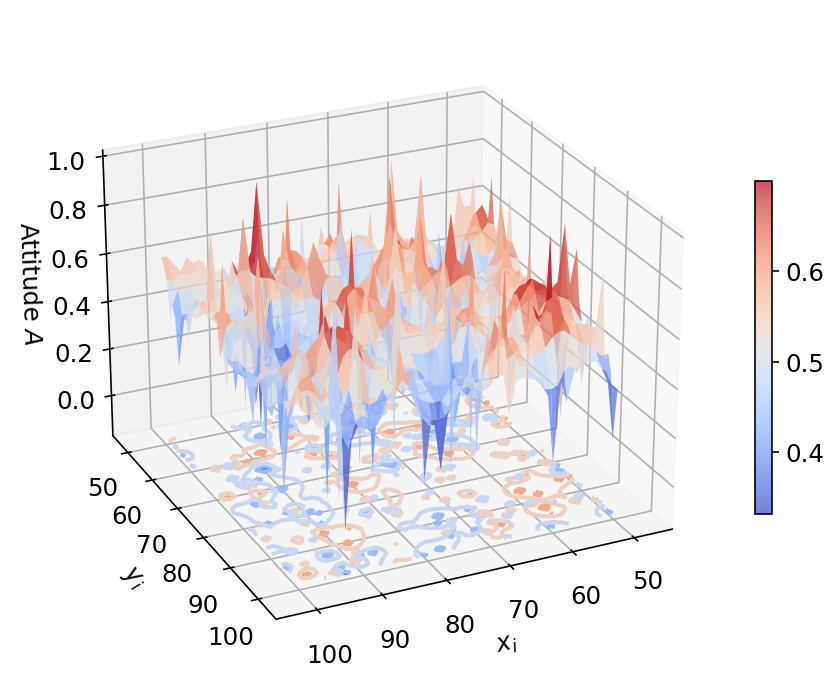

In [11]:
import matplotlib

file_uniform = "../data/distributions/agent_data_1000steps.csv"
data_uniform = LoadSimulation(file_uniform, columns=["step", "id", "affinity", "avantgarde", "affinityGoal", "seed"])

sample_uniform = data_uniform.query("seed == 100")

phi_m = np.linspace(50, 100, 50)
phi_p = np.linspace(50, 100, 50)
X,Y = np.meshgrid(phi_p, phi_m)
Z = Grid(Choice(sample_uniform, 1000))[50:, 50:]

fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(1,1,1, projection='3d')

offset = 5
cset=ax.plot_surface(X, Y, Z, rstride=2, cstride=2, alpha=0.7, cmap="coolwarm")
ax.contour(X, Y, Z, zdir='z', offset=-0.15, cmap="coolwarm", linewidths=2, linestyles='solid')

ax.set_xlim3d(-offset+50, 100 + offset)
ax.set_ylim3d(-offset+50, 100 + offset)
ax.set_zlim3d(-0.15, 1)
ax.set_proj_type('persp')
ax.view_init(elev=25, azim=65)
ax.grid(True)

plt.colorbar(cset, shrink=0.5)

ax.set_zlabel(r"Attitude $A$")
ax.set_xlabel(r"$x_i$")
ax.set_ylabel(r"$y_i$")
